In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os

from dask.distributed import Client

import cosima_cookbook as cc
from cosima_cookbook import explore

from statsmodels.tsa.seasonal import STL

import matplotlib.pyplot as plt
import cmocean as cm
import cf_xarray
import cftime
import cartopy.crs as ccrs

import xmovie
from xmovie import Movie
print("xmovie version", xmovie.__version__)

import warnings
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

map_path = "/g/data/ik11/grids/BlueMarble.tiff"
blue_marble = plt.imread(map_path)
blue_marble_extent = (-180, 180, -90, 90)

%matplotlib inline

xmovie version 0.3.1


In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43823,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:34277,Total threads: 1
Dashboard: /proxy/43795/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:37987,


2025-06-13 08:06:26,131 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-8564fa07ebc763185cc1e71019a01e2a', 598, 1, 1, 1) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('getitem-8564fa07ebc763185cc1e71019a01e2a', 598, 1, 1, 1)->('getitem-63d78bc9f5ad3650c0e6ca899e78f2fe', 598, 1, 1, 1))
new run_spec: Alias(('getitem-8564fa07ebc763185cc1e71019a01e2a', 598, 1, 1, 1)->('concatenate-open_dataset-temp-getitem-8564fa07ebc763185cc1e71019a01e2a', 598, 1, 1, 1))
old token: ('Alias', ('getitem-8564fa07ebc763185cc1e71019a01e2a', 598, 1, 1, 1), ('getitem-63d78bc9f5ad3650c0e6ca899e78f2fe', 598,

In [3]:
session = cc.database.create_session()

In [4]:
# dbx = explore.DatabaseExplorer(session=session)
# dbx

In [5]:
# ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
# ee

In [6]:
minlon = -240
maxlon = -60
midlon = (minlon + maxlon) / 2

minlat = -5
maxlat = +5
midlat = (minlat + maxlat) / 2

start_time = "1958-01-01 12:00:00"
end_time = "2018-12-31 12:00:00"
time_slice = slice(start_time, end_time)
climatology_baseline = slice("2000", None)

depth_slice = slice(0, 500)
lat_slice = slice(minlat, maxlat)
lon_slice = slice(minlon, maxlon)

In [7]:
resolution = "0.10" # "0.25" (for quicker) or "0.10" (for higher resolution, state of the art)

def load_variable(resolution, varname, start_time, end_time, depth_slice, lat_slice, lon_slice):

    if resolution == "0.25":
        experiment = "025deg_jra55_iaf_omip2_cycle6"
    elif resolution == "0.10":
        experiment = "01deg_jra55v140_iaf_cycle4"
    else:
        experiment = None

    var = cc.querying.getvar(expt=experiment, variable=varname,
                             session=session, frequency='1 monthly',
                             attrs={'cell_methods': 'time: mean'},
                             start_time=start_time, 
                             end_time=end_time,
                             chunks={})

    time_slice = slice(start_time, end_time)

    if lat_slice != None:
        var = var.cf.sel(latitude=lat_slice)

    if lon_slice != None:
        var = var.cf.sel(longitude=lon_slice)
        
    if depth_slice != None:
        var = var.cf.sel(vertical=depth_slice)

    return var

In [8]:
experiment = "01deg_jra55v140_iaf_cycle4"

minlon = -220
maxlon = -80

lat_slice = slice(-15, 15)
lon_slice = slice(minlon, maxlon)

temp = cc.querying.getvar(expt=experiment, variable='temp',
                         session=session, frequency='1 monthly',
                         attrs={'cell_methods': 'time: mean'},
                         start_time=start_time, 
                         end_time=end_time)

temp = temp.cf.sel(latitude=lat_slice).cf.sel(longitude=lon_slice)
temp

<xarray.DataArray 'temp' (time: 732, st_ocean: 75, yt_ocean: 304, xt_ocean: 1400)> Size: 93GB
dask.array<getitem, shape=(732, 75, 304, 1400), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 11kB -219.9 -219.8 -219.7 ... -80.15 -80.05
  * yt_ocean  (yt_ocean) float64 2kB -14.98 -14.88 -14.78 ... 14.78 14.88 14.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [9]:
# sst = cc.querying.getvar(expt=experiment, variable='surface_temp',
#                          session=session, frequency='1 monthly',
#                          # attrs={'cell_methods': 'time: mean'},
#                          start_time=start_time, 
#                          end_time=end_time)

In [10]:
lat_slice = slice(-5, 5)
temp = temp.cf.sel(latitude=lat_slice).cf.sel(longitude=lon_slice).cf.sel(vertical=depth_slice)
temp

<xarray.DataArray 'temp' (time: 732, st_ocean: 39, yt_ocean: 100, xt_ocean: 1400)> Size: 16GB
dask.array<getitem, shape=(732, 39, 100, 1400), dtype=float32, chunksize=(1, 19, 80, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 11kB -219.9 -219.8 -219.7 ... -80.15 -80.05
  * yt_ocean  (yt_ocean) float64 800B -4.944 -4.844 -4.745 ... 4.745 4.844 4.944
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [11]:
# sst = temp.isel(st_ocean=0)
# sst = sst.chunk({'yt_ocean': 304, 'xt_ocean': 1400})
# sst = sst.chunk('auto')
# sst.to_netcdf("sst-access-om2-iaf.nc")
# sst

Compute the nino34 index; just for sanity:

In [12]:
sst = temp.cf.sel(vertical=0, method="nearest")
nino34_region = sst.cf.sel(latitude=slice(-5, 5), longitude=slice(-170, -120))
climatology = nino34_region.cf.sel(time=climatology_baseline).groupby('time.month').mean(dim='time')
sst_anomaly = nino34_region.groupby('time.month') - climatology
nino34_index = sst_anomaly.cf.mean(dim=['latitude', 'longitude'])
nino34_index = nino34_index.rename("nino34")
nino34_index.persist()
nino34_index

<xarray.DataArray 'nino34' (time: 732)> Size: 3kB
dask.array<mean_agg-aggregate, shape=(732,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  (time) float64 6kB 0.5413 0.5413 0.5413 ... 0.5413 0.5413 0.5413
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

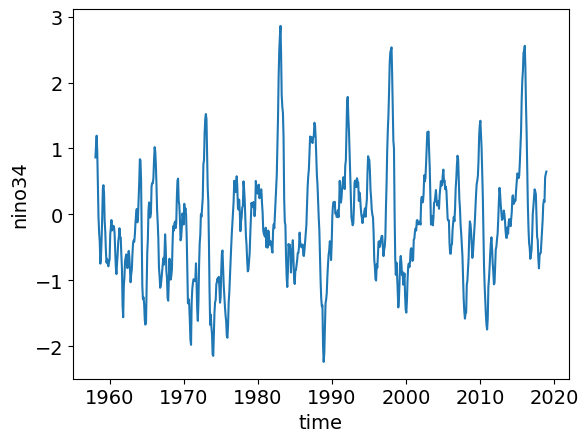

In [13]:
nino34_index.plot()

Compute anomaly based on climatology over `climatology_baseline` period.

In [14]:
temp_climatology = temp.cf.sel(time=climatology_baseline).groupby('time.month').mean(dim='time')
temp_anomaly = temp.groupby("time.month") - temp_climatology
temp_anomaly = temp_anomaly.rename("temp_anomaly")
temp_anomaly.persist()

<xarray.DataArray 'temp_anomaly' (time: 732, st_ocean: 39, yt_ocean: 100,
                                  xt_ocean: 1400)> Size: 16GB
dask.array<sub, shape=(732, 39, 100, 1400), dtype=float32, chunksize=(1, 19, 80, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 11kB -219.9 -219.8 -219.7 ... -80.15 -80.05
  * yt_ocean  (yt_ocean) float64 800B -4.944 -4.844 -4.745 ... 4.745 4.844 4.944
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [15]:
temp_anomaly = temp_anomaly.chunk(dict(time=-1))
temp_anomaly

<xarray.DataArray 'temp_anomaly' (time: 732, st_ocean: 39, yt_ocean: 100,
                                  xt_ocean: 1400)> Size: 16GB
dask.array<rechunk-merge, shape=(732, 39, 100, 1400), dtype=float32, chunksize=(732, 19, 80, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 11kB -219.9 -219.8 -219.7 ... -80.15 -80.05
  * yt_ocean  (yt_ocean) float64 800B -4.944 -4.844 -4.745 ... 4.745 4.844 4.944
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB dask.array<chunksize=(732,), meta=np.ndarray>

### Find the temp contour

### Detrending

In [16]:
def detrend1d_check(arr, period):
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det

def detrend_separate_check(da, dim, period):
    return xr.apply_ufunc(detrend1d_check, da, input_core_dims=[[dim]], output_core_dims=[[dim]], kwargs=dict(period=period), vectorize=True, dask='parallelized')
    
def detrend1d(arr, order=1):
    arr_det = detrend(arr, order) # order=1 for linear detrending
    return arr_det

def detrend3d(da, dim, order=1):
    # da = da.copy()
    return xr.apply_ufunc(detrend1d,
                          da,
                          input_core_dims=[[dim]],
                          output_core_dims=[[dim]],
                          kwargs=dict(order=order),
                          vectorize=True,
                          dask='parallelized')

def detrend_rolling_window(da, window_size=15):
    pad_size = window_size//2
    padded_data = da.pad(time=(pad_size, pad_size), mode='edge')
    smoothed_data = padded_data.rolling(time=window_size, center=True).mean('time').isel(time = slice(int(window_size/2),-int(window_size/2)))
    return da - smoothed_data

# this is linear detrending
# temp_anomaly_detrended = detrend3d(temp_anomaly, dim='time', order=1) 

Pick a point and plot the timeseries for sanity check.

In [17]:
## 

mixed_years = np.array([1908, 1910, 1916, 1917, 1922, 1949, 1995])

CP_years = np.array([1903, 1909, 1924, 1933, 1938, 1942, 1950, 1954,
                     1955, 1964, 1970, 1971, 1973, 1974, 1975, 1984,
                     1988, 1998, 1999, 2000, 2007, 2010, 2011, 2020,
                     2022])

EP_years = np.array([1906, 1962, 1967, 2017, 2021])

neutral_years = np.array([1901, 1907, 1912, 1921, 1923, 1926, 1927,
                          1928, 1929, 1931, 1932, 1934, 1935, 1936,
                          1943, 1944, 1945, 1946, 1947, 1948, 1952,
                          1953, 1958, 1959, 1960, 1978, 1980, 1981,
                          1983, 1989, 1990, 1993, 1996, 2001, 2008,
                          2012, 2013, 2016, 2019])

## After EOF analysis on ACCESS-OM2-01 SST
mixed_years = np.array([1908, 1910, 1916, 1917, 1922, 1949, 1995])

CP_years = np.array([1961, 1964, 1970, 1971, 1973, 1974,
                     1975, 1988, 1995, 1998, 1999, 2000,
                     2007, 2010, 2011])

EP_years = np.array([1966, 1967, 1984, 2017])

neutral_years = np.array([1959, 1960, 1962, 1969, 1977, 1978,
                          1980, 1981, 1983, 1985, 1989, 1990,
                          1993, 1996, 2001, 2003, 2004, 2005,
                          2008, 2012, 2013, 2014, 2016, 2018])

In [18]:
def get_individual_years(val,
                         season=[12, 1, 2],
                         years = np.arange(1960, 1991, 1),
                         standardise=False,
                         anomalies=True):
    """
    standarise = False (don't normalise; we want false for ocean)    
    """

    if anomalies:
        val_seasonal_mean_det = detrend_rolling_window(val.where(val.time.dt.month.isin(season), drop=True).resample(time = 'AS-JUN').mean('time'), #.chunk(dict(time=-1, lat=5, lon=10)),
                                                       window_size = 15)
    else:
        val_seasonal_mean_det = val.where(val.time.dt.month.isin(season), drop=True).resample(time = 'AS-JUN').mean('time')

    if standardise:
        return val_seasonal_mean_det.where(val_seasonal_mean_det.time.dt.year.isin(years), drop=True) / val_seasonal_mean_det.std()
    else:
        return val_seasonal_mean_det.where(val_seasonal_mean_det.time.dt.year.isin(years), drop=True)


In [19]:
# seasons
SON = [ 9, 10, 11]
DJF = [12,  1,  2]
MAM = [ 3,  4,  5]

In [21]:
temp_SON_d20_CP_years = get_individual_years(temp, years=CP_years, season=SON, anomalies=False)
temp_SON_d20_CP_composite = temp_SON_d20_CP_years.mean("time").load()
temp_SON_d20_EP_years = get_individual_years(temp, years=EP_years, season=SON, anomalies=False)
temp_SON_d20_EP_composite = temp_SON_d20_EP_years.mean("time").load()

temp_DJF_d20_CP_years = get_individual_years(temp, years=CP_years, season=DJF, anomalies=False)
temp_DJF_d20_CP_composite = temp_DJF_d20_CP_years.mean("time").load()
temp_DJF_d20_EP_years = get_individual_years(temp, years=EP_years, season=DJF, anomalies=False)
temp_DJF_d20_EP_composite = temp_DJF_d20_EP_years.mean("time").load()

temp_MAM_d20_CP_years = get_individual_years(temp, years=CP_years, season=MAM, anomalies=False)
temp_MAM_d20_CP_composite = temp_MAM_d20_CP_years.mean("time").load()
temp_MAM_d20_EP_years = get_individual_years(temp, years=EP_years, season=MAM, anomalies=False)
temp_MAM_d20_EP_composite = temp_MAM_d20_EP_years.mean("time").load()

In [23]:
temp_SON_CP_years = get_individual_years(temp_anomaly, years=CP_years, season=SON, anomalies=True)
temp_SON_CP_composite = temp_SON_CP_years.mean("time").load()
temp_SON_EP_years = get_individual_years(temp_anomaly, years=EP_years, season=SON, anomalies=True)
temp_SON_EP_composite = temp_SON_EP_years.mean("time").load()

temp_DJF_CP_years = get_individual_years(temp_anomaly, years=CP_years, season=DJF, anomalies=True)
temp_DJF_CP_composite = temp_DJF_CP_years.mean("time").load()
temp_DJF_EP_years = get_individual_years(temp_anomaly, years=EP_years, season=DJF, anomalies=True)
temp_DJF_EP_composite = temp_DJF_EP_years.mean("time").load()

temp_MAM_CP_years = get_individual_years(temp_anomaly, years=CP_years, season=MAM, anomalies=True)
temp_MAM_CP_composite = temp_MAM_CP_years.mean("time").load()
temp_MAM_EP_years = get_individual_years(temp_anomaly, years=EP_years, season=MAM, anomalies=True)
temp_MAM_EP_composite = temp_MAM_EP_years.mean("time").load()

Plot the composites

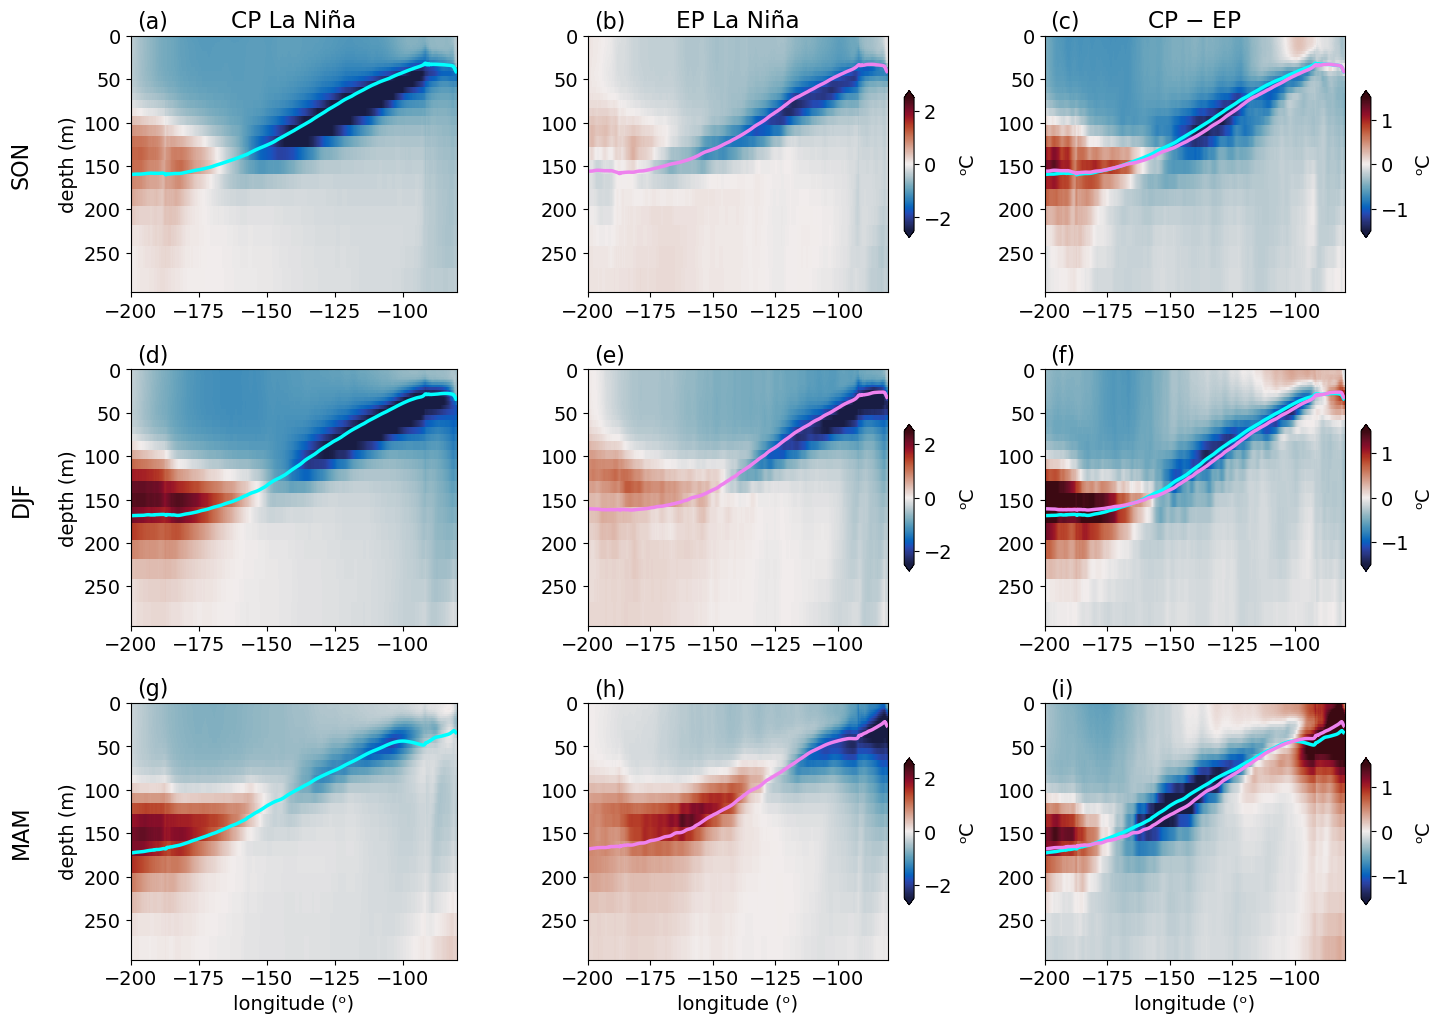

In [41]:
templim = 2.5
templim_diff = 1.5

cmap = cm.cm.balance
col_CP = "cyan"
col_EP = "violet"



fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.subplots_adjust(wspace=0.4) 
plt.subplots_adjust(hspace=0.3)



# SON

ax = axes[0, 0]
da = temp_SON_CP_composite
da20 = temp_SON_d20_CP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    add_colorbar=False
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)


ax = axes[0, 1]
da = temp_SON_EP_composite
da20 = temp_SON_d20_EP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)

ax = axes[0, 2]
da = temp_SON_CP_composite - temp_SON_EP_composite

hm = da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim_diff,
    vmax=+templim_diff,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)

(temp_SON_d20_CP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)

(temp_SON_d20_EP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)




# DJF


ax = axes[1, 0]
da = temp_DJF_CP_composite
da20 = temp_DJF_d20_CP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    add_colorbar=False
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)


ax = axes[1, 1]
da = temp_DJF_EP_composite
da20 = temp_DJF_d20_EP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)

ax = axes[1, 2]
da = temp_DJF_CP_composite - temp_DJF_EP_composite

hm = da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim_diff,
    vmax=+templim_diff,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)

(temp_DJF_d20_CP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)

(temp_DJF_d20_EP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)



# MAM

ax = axes[2, 0]
da = temp_MAM_CP_composite
da20 = temp_MAM_d20_CP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    add_colorbar=False
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)


ax = axes[2, 1]
da = temp_MAM_EP_composite
da20 = temp_MAM_d20_EP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim,
    vmax=+templim,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)
(da20 - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)


ax = axes[2, 2]
da = temp_MAM_CP_composite - temp_MAM_EP_composite

hm = da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-templim_diff,
    vmax=+templim_diff,
    extend="both",
    cmap=cmap,
    rasterized=True,
    cbar_kwargs={"label": "ᵒC",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)

(temp_MAM_d20_CP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_CP,
)

(temp_MAM_d20_EP_composite - 273.15).cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot.contour(
    levels=[20.,],
    linewidths=2.5,
    ax=ax,
    colors=col_EP,
)


axes[0, 0].set_title(r"CP La Niña")
axes[0, 1].set_title(r"EP La Niña")
axes[0, 2].set_title(r"CP $-$ EP")

for ax in (axes[0, 0], axes[0, 1], axes[0, 2],
           axes[1, 0], axes[1, 1], axes[1, 2],
           axes[2, 0], axes[2, 1], axes[2, 2]):
    ax.invert_yaxis()

for ax in (axes[0, 0], axes[0, 1], axes[0, 2],
           axes[1, 0], axes[1, 1], axes[1, 2]):
    ax.set_xlabel("")

for ax in (axes[2, 0], axes[2, 1], axes[2, 2]):
    ax.set_xlabel("longitude (ᵒ)")

for ax in (axes[0, 0],
           axes[1, 0],
           axes[2, 0]):
    ax.set_ylabel("depth (m)")

for ax in (axes[0, 1], axes[0, 2],
           axes[1, 1], axes[1, 2],
           axes[2, 1], axes[2, 2]):
    ax.set_ylabel("")

axes[2, 1].set_ylabel("")
axes[2, 2].set_ylabel("")

import string
# Panel labels: (a), (b), ...
panel_labels = list(string.ascii_lowercase)

season_labels = ['SON', 'DJF', 'MAM']

for i in range(3):  # rows
    for j in range(3):  # columns
        ax = axes[i, j]
        
        # Add panel label
        label = f"({panel_labels[i * 3 + j]})"
        ax.text(0.02, 1.1, label, transform=ax.transAxes,
                fontsize=16, va='top')

    axes[i, 0].text(-0.3, 0.5, season_labels[i],
                    transform=axes[i, 0].transAxes,
                    fontsize=16, #fontweight='bold',
                    va='center', ha='right',
                    rotation='vertical')


plt.savefig("ocean-LaNina-CP-EP.pdf", bbox_inches='tight', dpi=300);

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

da = temp_CP_composite - temp_EP_composite

da.cf.sel(vertical=slice(0, 300)).cf.sel(longitude=slice(-200, None)).cf.mean("latitude").plot(
    ax=ax,
    vmin=-3.5,
    vmax=+3.5,
    extend="both",
    cmap="RdBu_r",
    cbar_kwargs={"label": "temp anomaly (deg)",
                 "fraction": 0.03,
                 "aspect": 15,
                 "shrink": 0.7},
)

ax.invert_yaxis()

In [ ]:
axs[0, 0]

In [ ]:
temp_EP_composite.cf.mean('latitude').plot()

In [ ]:
random_location = {"vertical": 0, "latitude": 1, "longitude": -100}

plt.figure()
temp_anomaly.cf.sel(random_location, method='nearest').plot(label="original")
temp_anomaly_detrended.cf.sel(random_location, method='nearest').plot(label="detrended")
plt.legend()

Average over the latitude range

In [ ]:
temp_anomaly_detrended_latmean = temp_anomaly_detrended.cf.mean("latitude")
temp_anomaly_detrended_latmean

Save as netCDF for quicker load!

In [ ]:
filename = "temp_anomaly_detrended_latmean-" + resolution.replace(".", "p")

if os.path.exists(filename + ".nc"):
    print("The file " + filename + ".nc" + " already exists.")
else:
    print("The file " + filename + ".nc" + " does not exist. Saving it now...")
    temp_anomaly_detrended_latmean.to_netcdf(filename + ".nc")

Load the temperature anomaly (detrended and averaged over latitude range around the equator) from the netCDF file!

In [ ]:
temp_anomaly = xr.open_dataarray(filename + ".nc")
temp_anomaly

In [ ]:
def plot_temp(da, fig, timestamp, *args, **kwargs):

    ax = fig.add_subplot(1, 1, 1)

    da.isel(time=timestamp).plot(
        ax=ax,
        vmin=-3.5,
        vmax=+3.5,
        extend="both",
        cmap="RdBu_r",
        cbar_kwargs={"label": "temp anomaly (deg)",
                     "fraction": 0.03,
                     "aspect": 15,
                     "shrink": 0.7},
    )

    ax.set_title(da['time'].dt.strftime('%d-%m-%Y')[timestamp].item())

    ax.invert_yaxis()
    ax.set_ylabel("depth (m)")
    ax.set_xlabel("longitude (degE)")

    return ax, None

Plot a frame of the movie to check it out.

In [ ]:
fig = plt.figure()

plot_temp(temp_anomaly, fig, 0)

Create a movie object! Chunk the data array to use `parallel=True` when saving the movie.

In [ ]:
fig = plt.figure()

mov = Movie(temp_anomaly.chunk({'time': 1}), plot_temp);

In [ ]:
mov.preview(0)

In [ ]:
mov.save(filename + ".mp4",
         progress=True,
         framerate=3,
         overwrite_existing=True,
         remove_movie=False,
         parallel=True,
         parallel_compute_kwargs=dict(scheduler="processes", num_workers=12)
        )